In [1]:
import pandas as pd

In [2]:
data_folder = "../data"
pics_folder = "../pics/2"

In [3]:
df = pd.read_csv(f'{data_folder}/nn_1.csv').rename(columns=str.lower)

In [4]:
df.columns

Index(['x1', 'x2', 'class'], dtype='object')

In [5]:
features = ["x1", "x2"]
target = "class"

In [6]:
df[target] = df[target].map({-1: 0, 1:1})

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df[target])

In [9]:
import torch

In [10]:
X_train, y_train = torch.FloatTensor(train_df[features].values), torch.FloatTensor(train_df[target].values)
X_test, y_test = torch.FloatTensor(train_df[features].values), torch.FloatTensor(train_df[target].values)

In [11]:
import torch.nn as nn

In [12]:
class ImprovedNet(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.LeakyReLU(0.03),
            nn.Dropout(0.25),
            nn.Linear(64, 32),
            nn.LeakyReLU(0.01),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.net(x)

In [13]:
import torch.optim as optim

In [14]:
model = ImprovedNet(X_train.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)

In [15]:
train_losses = []
test_losses = []
best_loss = float('inf')
patience = 10
no_improve = 0

In [16]:
from tqdm import tqdm

In [17]:
n_iter = 1_000

In [18]:
for epoch in tqdm(range(n_iter)):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train).squeeze()
    loss = criterion(outputs, y_train.squeeze())
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test).squeeze()
        test_loss = criterion(test_outputs, y_test.squeeze())
        test_losses.append(test_loss.item())
    
    if test_loss < best_loss:
        best_loss = test_loss
        no_improve = 0
    else:
        no_improve += 1
    
    if no_improve >= patience:
        print(f'Early stopping at {(epoch + 1)=}')
        break
    
    scheduler.step(test_loss)

 42%|████████████████████▏                           | 420/1000 [00:00<00:00, 741.56it/s]

Early stopping at (epoch + 1)=421


In [19]:
best_loss.item()

0.031033338978886604

In [20]:
import matplotlib.pyplot as plt

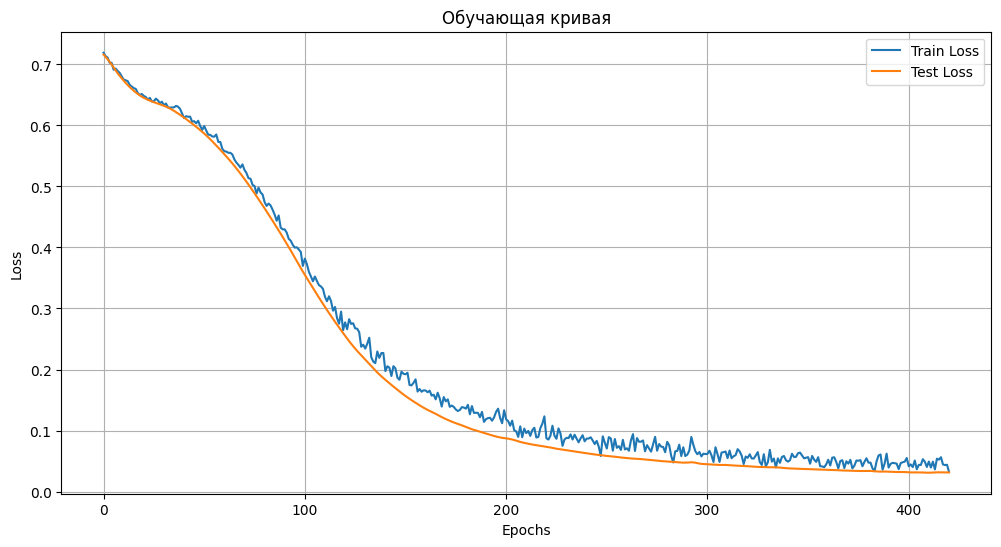

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Обучающая кривая')
plt.legend()
plt.grid(True)
plt.savefig(f"{pics_folder}/learning.png")
plt.show()